In [1]:
#https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/infogan/infogan.py

import os
import matplotlib.pyplot as plt
from collections import OrderedDict
import itertools
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint


if not os.path.exists("data/MNIST"):
    MNIST("data", train=True, download=True)
    MNIST("data", train=False, download=True)

batch_size = 64
num_workers = 8
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
    
train_data = MNIST("data", train=True, transform=transform)
test_data = MNIST("data", train=False, transform=transform)

train_dataloader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
valid_dataloader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [2]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, n_classes=10, code_dim=2):
        super().__init__()
        self.input_dim = latent_dim + n_classes + code_dim
        self.init_dim = 28 // 4
        self.n_classes = n_classes
        
        self.linear_projection = nn.Linear(self.input_dim, 128 * self.init_dim ** 2)
        
        self.blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1)
        )
        

    def forward(self, z, label, code):
        label = F.one_hot(label, self.n_classes)
        
        x = torch.cat((z, label, code), -1)
        x = self.linear_projection(x)
        x = x.view(x.shape[0], 128, self.init_dim, self.init_dim)
        x = self.blocks(x)
        
        return F.tanh(x)
    
    
class Discriminator(nn.Module):
    def __init__(self, n_classes=10, code_dim=2):
        super().__init__()
        
        def discriminator_block(in_channels, out_channels, bn=True):
            block = [
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout2d(0.25)
            ]
            
            if bn:
                block.append(nn.BatchNorm2d(out_channels, 0.8))

            return block
        
        self.blocks = nn.Sequential(
            *discriminator_block(1, 16, bn=False),
            *discriminator_block(16, 32, bn=True),
            *discriminator_block(32, 64, bn=True),
            *discriminator_block(64, 128, bn=True)
        )
        
        downsampled_dim = 28 // 2 ** 4
        
        self.adversarial_layer = nn.Linear(512, 1)
        self.auxiliary_layer = nn.Linear(512, n_classes)
        self.latent_layer = nn.Linear(512, code_dim)
        
        
    def forward(self, x):
        x = self.blocks(x)
        x = x.view(x.shape[0], -1)
        
        validity = F.sigmoid(self.adversarial_layer(x))
        label = F.softmax(self.auxiliary_layer(x))
        latent_code = self.latent_layer(x)
        
        return validity, label, latent_code
    

In [3]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

        
class InfoGAN(pl.LightningModule):
    def __init__(self, latent_dim=62, n_classes=10, code_dim=2,
                 lambda_class=1, lambda_code=0.1):
        super().__init__()
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        self.code_dim = code_dim
        
        self.lambda_class = lambda_class
        self.lambda_code = lambda_code
        
        self.generator = Generator(latent_dim=latent_dim, n_classes=n_classes, code_dim=code_dim)
        self.generator.apply(weights_init_normal)
        
        self.discriminator = Discriminator(n_classes=n_classes, code_dim=code_dim)
        self.discriminator.apply(weights_init_normal)
        
    
    def forward(self, z, label, code):
        return self.generator(z, label, code) 
    
    
    def sample_latent(self, batch_size):
        sampled_z = torch.randn(batch_size, self.latent_dim).to("cuda")
        sampled_label = torch.randint(0, self.n_classes, (batch_size, )).to("cuda")
        sampled_code = torch.FloatTensor(batch_size, self.code_dim).uniform_(-1, 1).to("cuda")
        
        return sampled_z, sampled_label, sampled_code
    
    
    def generator_step(self, imgs):
        valid = torch.ones(imgs.size(0), 1).to("cuda")
        
        z, label, code = self.sample_latent(imgs.shape[0])
        generated_imgs = self(z, label, code)
        validity, _, _ = self.discriminator(generated_imgs)
        
        g_loss = F.binary_cross_entropy(validity, valid)
        
        return g_loss
    
    
    def discriminator_step(self, imgs):
        valid = torch.ones(imgs.size(0), 1).to("cuda")
        fake = torch.zeros(imgs.size(0), 1).to("cuda")
        
        real_validity, _, _ = self.discriminator(imgs)
        real_loss = F.binary_cross_entropy(real_validity, valid)
    
        z, label, code = self.sample_latent(imgs.shape[0])
        generated_imgs = self(z, label, code)
        fake_validity, _, _ = self.discriminator(generated_imgs.detach())
        fake_loss = F.binary_cross_entropy(fake_validity, fake)
        
        d_loss = (real_loss + fake_loss) / 2
        
        return d_loss
    
    
    def mutual_info_step(self, imgs):
        z, label, code = self.sample_latent(imgs.shape[0])
        generated_imgs = self(z, label, code)
        _, pred_label, pred_code = self.discriminator(generated_imgs)
        
        categorical_loss = F.cross_entropy(pred_label, label)
        code_loss = F.mse_loss(pred_code, code)
        
        info_loss = self.lambda_class * categorical_loss + self.lambda_code * code_loss
        
        return info_loss
    
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        imgs, labels = batch
        
        # generator
        if optimizer_idx == 0:
            g_loss = self.generator_step(imgs)
            self.log('train_g_loss', g_loss, on_step=False, on_epoch=True, prog_bar=True)
            return g_loss
        # discriminator
        elif optimizer_idx == 1:
            d_loss = self.discriminator_step(imgs)
            self.log('train_d_loss', d_loss, on_step=False, on_epoch=True, prog_bar=True)
            return d_loss
        # mutual information
        elif optimizer_idx == 2:
            info_loss = self.mutual_info_step(imgs)
            self.log('train_i_loss', info_loss, on_step=False, on_epoch=True, prog_bar=True)
            return info_loss
            
    
    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        
        g_loss = self.generator_step(imgs)
        d_loss = self.discriminator_step(imgs)
        info_loss = self.mutual_info_step(imgs)
        
        self.log('valid_g_loss', g_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('valid_d_loss', d_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('valid_i_loss', info_loss, on_step=False, on_epoch=True, prog_bar=True)
        
    def configure_optimizers(self):
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        opt_info = torch.optim.Adam(
            itertools.chain(self.generator.parameters(), self.discriminator.parameters()), 
            lr=0.0002, betas=(0.5, 0.999))
        
        return [opt_g, opt_d, opt_info], []


callbacks = [
    ModelCheckpoint(monitor='valid_g_loss', save_top_k=3, dirpath='weights/InfoGAN', filename='InfoGAN-{epoch:03d}-{valid_g_loss:.4f}-{valid_d_loss:.4f}'),
]
    
model = InfoGAN()
trainer = pl.Trainer(gpus=1, max_epochs=200, enable_progress_bar=True, callbacks=callbacks)

/home/ubuntu/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:429: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
# trainer.fit(model, train_dataloader, valid_dataloader)

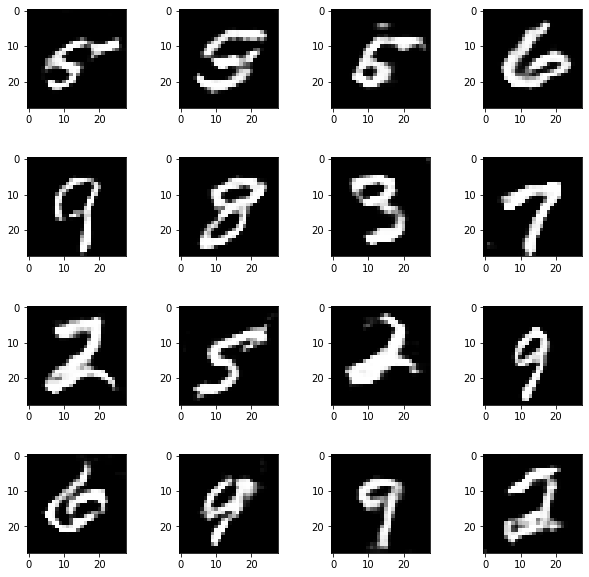

In [6]:
ckpt_fname = "InfoGAN-epoch=031-valid_g_loss=0.7667-valid_d_loss=0.6858.ckpt"
model = model.load_from_checkpoint("weights/InfoGAN/" + ckpt_fname)

model.generator.to("cuda")
model.generator.eval()

samples = model(torch.randn(16, 62).to("cuda"), 
                torch.randint(0, 10, (16, )).to("cuda"), 
                torch.FloatTensor(16, 2).uniform_(-1, 1).to("cuda")
               ).view(-1, 1, 28, 28)
samples = samples.detach().moveaxis(1, -1).to("cpu").numpy()

plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(samples[i, :], cmap="gray")

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


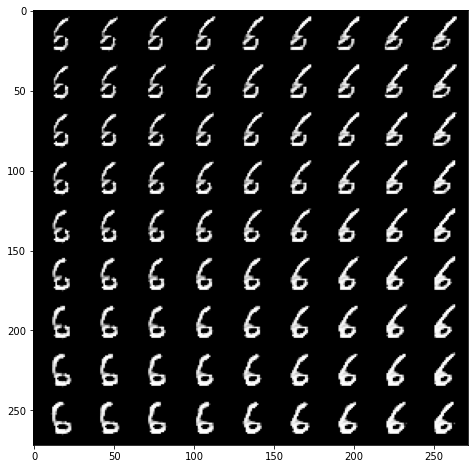

In [58]:
from torchvision.utils import make_grid

z = torch.randn(1, 62).to("cuda")
label = torch.tensor([5, ]).to("cuda")

samples = torch.zeros([81, 1, 28, 28])

count = 0
for c1 in np.arange(-1., 1.1, 0.25):
    for c2 in np.arange(-1., 1.1, 0.25):
        sample = model(z, label, torch.tensor([c1, c2]).unsqueeze(0).float().to("cuda")).view(-1, 1, 28, 28)
        sample = sample.detach().to("cpu")
        samples[count, :] = sample
        count += 1

plt.figure(figsize=(8, 8))
plt.imshow(make_grid(samples, nrow=9, normalize=False).permute(1, 2, 0))
plt.show()